First, let's load the data from the CSV file into a numpy array and separate it into targets and features.

In [24]:
import numpy as np

data = np.genfromtxt('internship_train.csv', 
                     delimiter=',', 
                     skip_header=1)

rows, cols = data.shape

features = data[:, :cols - 1]
targets = data[:, cols - 1]

print(features.shape)
print(targets.shape)

(90000, 53)
(90000,)


The dataset contains 90000x53 floating-point numbers and 90000 targets of the same type. 
There are no missing values. The dataset it pretty large, so we will use Stochastic Gradient Descent and parallelization in order to minimize the time and space complexity required to train the model.

Let's look for correlations between feature columns:

In [25]:
for i in range(cols - 1):
    for j in range(i + 1, cols - 1):
        corr = np.corrcoef(features[:, i], features[:, j])[0][1]
        if (corr > 0.1):
            print(f'correlation between {i} and {j} is {corr}')

correlation between 6 and 8 is 0.940015649134094


This correlation is pretty high, so we might consider dropping one of these features later on.

Let's make 53 plots to see how do correlations between every one of them and the target look:

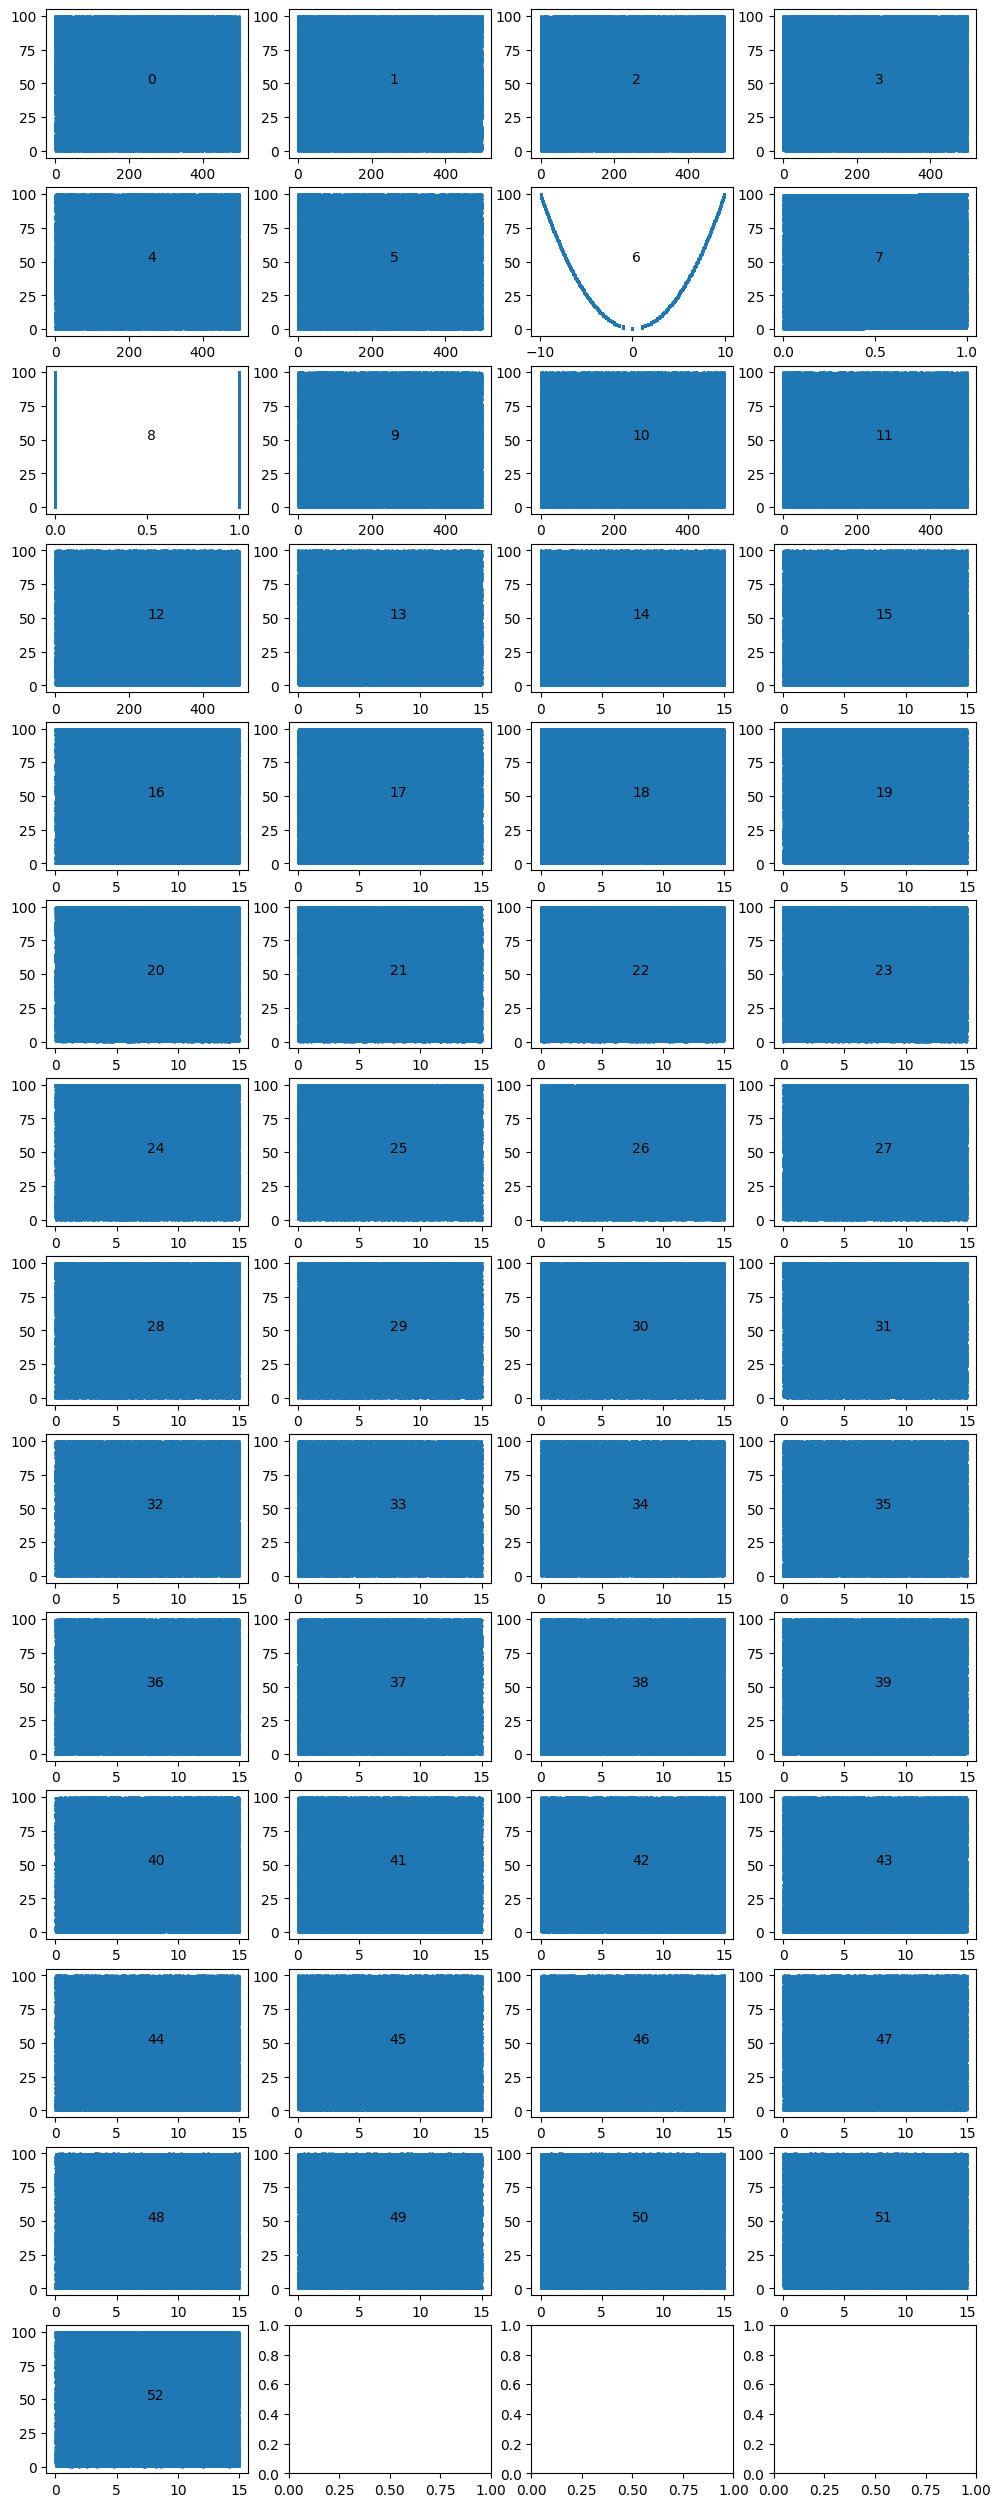

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=14, ncols=4, figsize=(12, 32))

for i in range(cols - 1):
    ax = axs[i // 4, i % 4]
    ax.scatter(features[:, i], targets, s=1)
    ax.text(0.5, 0.5, str(i), transform=ax.transAxes)

plt.show()

As we can see, all features except 6 and 8 are mostly noise. So let's narrow down our features array to those two:

In [27]:
features = features[:, [6, 8]]

Let's plot these two again:

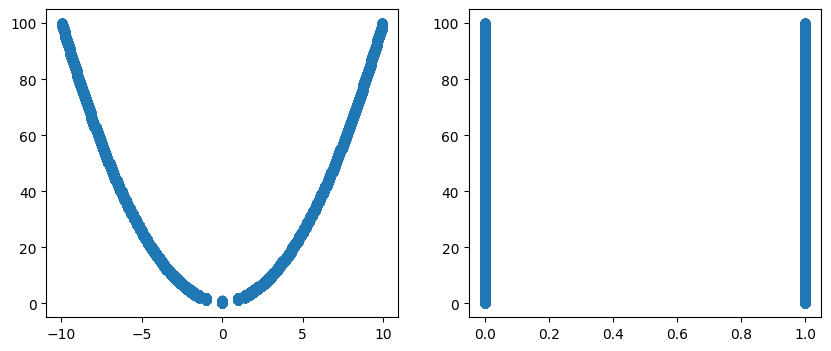

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].scatter(features[:, 0], targets)
axs[1].scatter(features[:, 1], targets)
plt.show()

Clearly, the second feature doesn't give us any information about the target. So we will drop it.

The first feature is easy to hypothesize about. It looks like a normal parabola and we can do regression with gradient descent to find the best arguments a and b for the function y = a * x^2 + b, which will predict the targets.

Let's drop the second feature and normalize the data:

In [32]:
features = features[:, 0].reshape(rows, 1)

mean = np.mean(features)
std = np.std(features)
features = (features - mean) / std

mean = np.mean(targets)
std = np.std(targets)
targets = (targets - mean) / std

Let's add squares of the feature to our dataset:

In [33]:
features = np.hstack([features, np.square(features)])

Let's look at the correlation between the squared feature and the targets:

In [34]:
np.corrcoef(features[:, 1], targets)

array([[1.        , 0.99993456],
       [0.99993456, 1.        ]])

As we can see, it is very close to 100%.

Now we can create a model inside the scope of the MirroredStrategy distribution strategy. We will use Stochastic Gradient Descent as the optimizer, MSE as the loss function, and RMSE as our metric.

Now let's look for the best learning rate to achieve fastest convergence:

In [35]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

def get_model(learning_rate):
    strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(2,)),
            tf.keras.layers.Dense(units=1)
        ])
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        loss = tf.keras.losses.MeanSquaredError()
        metric = tf.keras.metrics.RootMeanSquaredError()

    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=[metric])
    
    return model

Let's test different learning rates:

In [36]:
ds = tf.data.Dataset.from_tensor_slices((features, targets)).shuffle(rows).batch(256)
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
ds = ds.with_options(options)

for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1]:
    print(f'Testing with learning_rate = {learning_rate}:')
    model = get_model(learning_rate)
    epochs = 20 if learning_rate < 0.01 else 5
    model.fit(ds, epochs=epochs)

Testing with learning_rate = 0.001:
Epoch 1/20
352/352 [==============================] - 4s 7ms/step - loss: 0.7859 - root_mean_squared_error: 0.8865
Epoch 2/20
352/352 [==============================] - 2s 7ms/step - loss: 0.4169 - root_mean_squared_error: 0.6457
Epoch 3/20
352/352 [==============================] - 2s 7ms/step - loss: 0.3080 - root_mean_squared_error: 0.5550
Epoch 4/20
352/352 [==============================] - 3s 7ms/step - loss: 0.2420 - root_mean_squared_error: 0.4919
Epoch 5/20
352/352 [==============================] - 2s 7ms/step - loss: 0.1931 - root_mean_squared_error: 0.4394
Epoch 6/20
352/352 [==============================] - 2s 6ms/step - loss: 0.1548 - root_mean_squared_error: 0.3934
Epoch 7/20
352/352 [==============================] - 2s 6ms/step - loss: 0.1243 - root_mean_squared_error: 0.3525
Epoch 8/20
352/352 [==============================] - 2s 7ms/step - loss: 0.0998 - root_mean_squared_error: 0.3159
Epoch 9/20
352/352 [========================

Based on the results, we can say that learning rates below 0.01 are too slow and don't provide any benefit, and the training still converges with the learning rate of 0.1.

Finally, let's save the model and the mean and standard deviation of the targets (to reverse normalized outputs of the model into targets as they were in the file internship_train.csv originally):

In [21]:
model.save('model.h5')
with open('targets_specs.txt', 'w') as f:
    f.write(f'{mean} {std}')